In [9]:
NAME = "Michael Cornelisse"
STUDENT_NUMBER = "s1059020"
COLLABORATOR_NAME = "Nienke Helmers"
COLLABORATOR_STUDENT_NUMBER = "s1016904"

In [10]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [11]:
# Load data
#actual_data = pd.read_csv('data/archive/actual.csv')
patient_data = pd.read_csv('data/archive/actual.csv', index_col = 'patient')
train_data = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
test_data = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')

# Drop the call collumns from both data sets
call_cols_train = [col for col in train_data.columns if 'call' in col]
train_data = train_data.drop(call_cols_train, axis = 1)

call_cols_test = [col for col in test_data.columns if 'call' in col]
test_data = test_data.drop(call_cols_test, axis = 1)

# Drop "Gene Description" and "Gene Accession Number"
cols_to_drop = ['Gene Description', 'Gene Accession Number']
train_data = train_data.drop(cols_to_drop, axis = 1)
test_data = test_data.drop(cols_to_drop, axis = 1)

# Transpose both data_sets
train_data = train_data.T
test_data = test_data.T

# Clean the patient_data
patient_data = patient_data.replace({'ALL': 0, 'AML': 1})
patient_train = patient_data[patient_data.index <= 38]
patient_test = patient_data[patient_data.index > 38]

# Merge train and test datasets
complete_data = train_data.append(test_data)

complete_data.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


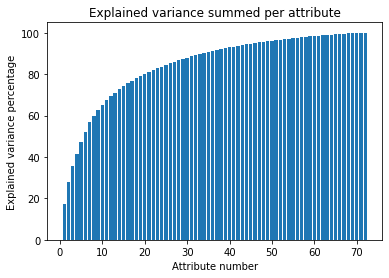

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including the current attribute number, for example the tenth attribute shows the sum of attributes 1 to 10.
There are 33 attributes that together explain 90% of the variance.
(38, 33)


In [12]:
# Data pre-processing
#PCA
pca = PCA()
pca_data = pca.fit_transform(complete_data)

#Calculate and plot explained variance PCA
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio * 100
plt.bar(range(1,pca_variance_percentage.size+1), pca_variance_percentage)
plt.title("Explained variance summed per attribute")
plt.xlabel("Attribute number")
plt.ylabel("Explained variance percentage")
plt.show()
print("Figure: A plot of the explained variance. The variance is summed for all attributes up to and including the current attribute number, for example"
     " the tenth attribute shows the sum of attributes 1 to 10.")

#Determine number of attributes needed for an explained variance of 90%
pca_variance_cropped = [i for i in pca_variance_percentage if i <= 90]
no_attributes = len(pca_variance_cropped)
print("There are {} attributes that together explain 90% of the variance." .format(no_attributes))

#Crop pca_data
pca_data = np.delete(pca_data, slice(no_attributes, len(pca_data)) , 1)

#Split data back to original train and test split
pca_train = pca_data[:38]
pca_test = pca_data[38:]

print(pca_train.shape)

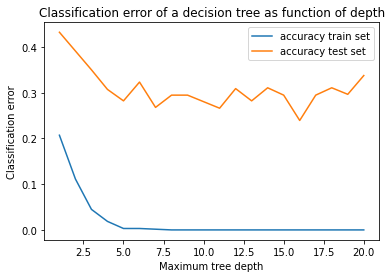

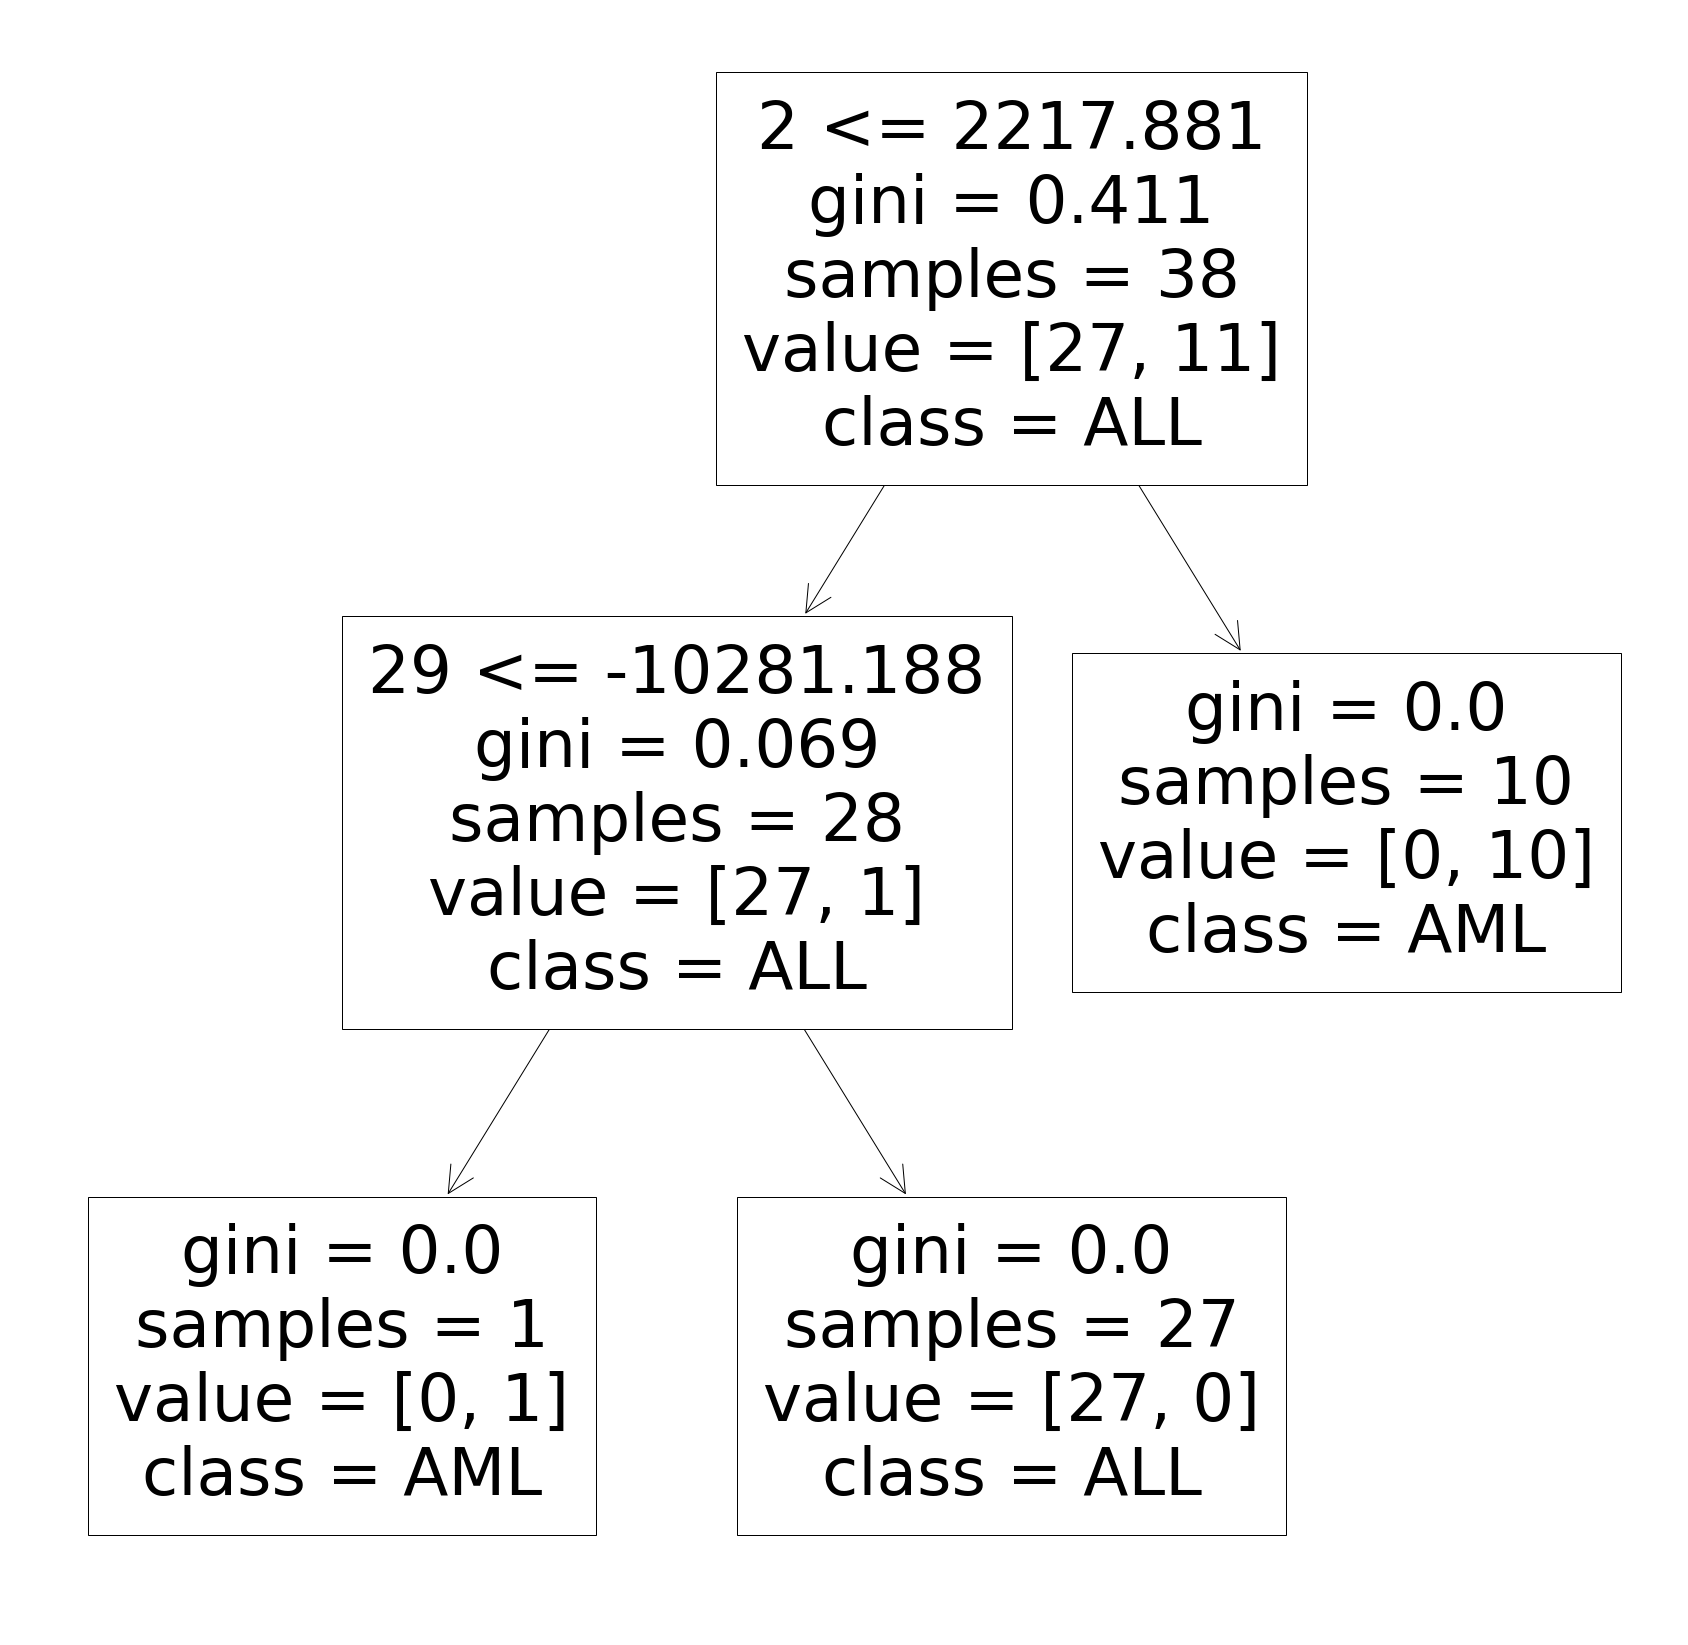

The standard decision tree has an accuracy of 0.5588235294117647 and an error rate of 0.4411764705882353.


In [14]:
# Classification Decision Tree
#Find best depth
kf = KFold(n_splits=10)

accuracy_mean_train = np.array([])
accuracy_mean_test = np.array([])

patient_data = patient_data.to_numpy()

for i in range(1, 21):
    accuracy_train = np.array([])
    accuracy_test = np.array([])
    for train, test in kf.split(pca_data, patient_data):
        split_clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = i)
        split_clf = split_clf.fit(pca_data[train], patient_data[train])

        accuracy_train = np.append(accuracy_train, metrics.accuracy_score(patient_data[train], split_clf.predict(pca_data[train])))
        accuracy_test = np.append(accuracy_test, metrics.accuracy_score(patient_data[test], split_clf.predict(pca_data[test]))) 
    accuracy_mean_train = np.append(accuracy_mean_train, np.mean(accuracy_train))
    accuracy_mean_test = np.append(accuracy_mean_test, np.mean(accuracy_test))

plt.plot(range(1,21), (1-accuracy_mean_train), label='accuracy train set')
plt.plot(range(1,21), (1-accuracy_mean_test), label='accuracy test set')
plt.legend()
plt.xlabel('Maximum tree depth')
plt.ylabel('Classification error')
plt.title('Classification error of a decision tree as function of depth')
plt.show()

#Final decision tree
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = 4)
clf = clf.fit(pca_train, patient_train)
plt.figure(figsize=(30, 30))
tree.plot_tree(clf, feature_names = range(1,34), class_names = ['ALL' , 'AML'])
plt.show()

accuracy = metrics.accuracy_score(patient_test, clf.predict(pca_test))
print("The standard decision tree has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

#Potentially add confusion matrix with heatmap

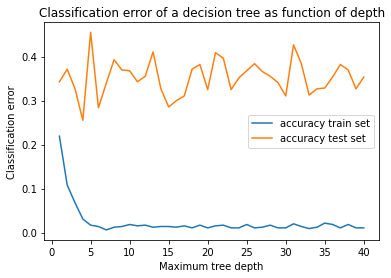

In [25]:
# Classification Random Forest
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#patient_train = patient_train.to_numpy()
patient_train = patient_train.ravel()

rf = RandomForestClassifier(n_estimators = 10, criterion='gini', max_depth = 10)
rf.fit(pca_train, patient_train)

accuracy = metrics.accuracy_score(patient_test, rf.predict(pca_test))
error = 1-accuracy

accuracy_mean_train = np.array([])
accuracy_mean_test = np.array([])

#patient_data = patient_data.to_numpy()
patient_data = patient_data.ravel()

for i in range(1, 41):
    accuracy_train = np.array([])
    accuracy_test = np.array([])
    for train, test in kf.split(pca_data, patient_data):
        rf = RandomForestClassifier(n_estimators = 10, criterion='gini', max_depth = i)
        rf = rf.fit(pca_data[train], patient_data[train])

        accuracy_train = np.append(accuracy_train, metrics.accuracy_score(patient_data[train], rf.predict(pca_data[train])))
        accuracy_test = np.append(accuracy_test, metrics.accuracy_score(patient_data[test], rf.predict(pca_data[test]))) 
    accuracy_mean_train = np.append(accuracy_mean_train, np.mean(accuracy_train))
    accuracy_mean_test = np.append(accuracy_mean_test, np.mean(accuracy_test))

plt.plot(range(1,41), (1-accuracy_mean_train), label='accuracy train set')
plt.plot(range(1,41), (1-accuracy_mean_test), label='accuracy test set')
plt.legend()
plt.xlabel('Maximum tree depth')
plt.ylabel('Classification error')
plt.title('Classification error of a decision tree as function of depth')
plt.show()

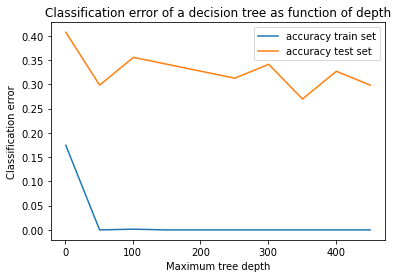

In [31]:
accuracy_mean_train = np.array([])
accuracy_mean_test = np.array([])

for i in range(1, 501,50):
    accuracy_train = np.array([])
    accuracy_test = np.array([])
    for train, test in kf.split(pca_data, patient_data):
        rf = RandomForestClassifier(n_estimators = i, criterion='gini', max_depth = 4)
        rf = rf.fit(pca_data[train], patient_data[train])

        accuracy_train = np.append(accuracy_train, metrics.accuracy_score(patient_data[train], rf.predict(pca_data[train])))
        accuracy_test = np.append(accuracy_test, metrics.accuracy_score(patient_data[test], rf.predict(pca_data[test]))) 
    accuracy_mean_train = np.append(accuracy_mean_train, np.mean(accuracy_train))
    accuracy_mean_test = np.append(accuracy_mean_test, np.mean(accuracy_test))

plt.plot(range(1,  501,50), (1-accuracy_mean_train), label='accuracy train set')
plt.plot(range(1,  501,50), (1-accuracy_mean_test), label='accuracy test set')
plt.legend()
plt.xlabel('Maximum tree depth')
plt.ylabel('Classification error')
plt.title('Classification error of a decision tree as function of depth')
plt.show()

In [ ]:
https://medium.com/@snk.nitin/decision-trees-random-forests-and-pca-e676e4c142c6
    
In contrast, a white box model allows you to see exactly what goes on at each step, enabling you to perform the task manually if it suits you. 
Decision trees make very few assumptions about the training data and if left unconstrained they would adapt themselves to the data most likely overfit.

In [ ]:
# Data pre-processing

# Standarditization -> not necessary because decision trees are based on comparison of values and 
# scaling has no effect on the final outcome: -2947 is smaller than 2947 an the same is true for -2 and 2

# PCA -> probably better for fast result, but loose explainability, as reasoned below
'''https://www.researchgate.net/post/the_effect_PCA_in_decision_tree 
A short possible answer:
You will no longer be able to give a nice interpretation to the decision tree, which is one of the main reason why people use them... 
On the other side, PCA might give a better representation of the data, which might (but also might not, it depends on the data itself) 
benefit any classifier (not only decision trees).

A longer answer:
As others have pointed out, PCA is a technique that projects your original data into a new coordinate space. For example, 
let's assume that you have a dataset with three features x1, x2 and x3. Then, you can find a new set of coordinates z1, z2, z3 
(the PCA space) and project your data into this new coordinate system.

With PCA, every of these new coordinates (or principal components) are a linear combination of the original features. For example:
z1 = a*x1 + b*x2 + c*x3
z2= d*x1 + e*x2 + f*x3
z3 = h*x1 + h*x2 + i*x3

The objective of PCA is find the coefficients a, b, c, ... such that z1 retains the maximum variance, z2 the second highest, and so on.
When using all the principal components, you have exactly the same information, just represented in a different way. This might, or might not, be useful 
for your classifier. It depends on the data itself. If you decide to use a lower number of principal components, you will be reducing the dimensionality of 
your data. In the previous example, you might use only z1 and z2 only, reducing your data from 3, to only 2 features. Depending on your data, this might 
help classifiers to reduce the chance of overfitting, mainly if the number of instances in your dataset is relatively small. Note that this would apply to all the 
classifiers, not only decision trees. Again, this might, or might not improve the performance of your classifier, it depends on the properties of the data.

An important point with respect to decision trees: People like to use them because they are easy to explain. You can analyze the tree and check how it reached 
its final decision. If you apply PCA, then the decision tree will split the data based on z1, z2, z3. Since z1, z2 and z3 are now abstract features (they are a 
linear combination of the original ones) you can no longer give a nice explanation of what is doing.

Putting a concrete example, imagine that your features are age, height, and weight. It is easy to understand (and to explain) If the age is > 30 go 
left, otherwise go right. If you apply PCA you would be saying is 0.3*age + 1.5*height - 0.4*weight is < 13.5 go left, otherwise go right. As 
you can see, you have lost all the 'explainability' of the decision tree, which is one of its main characteristics.'''

In [ ]:
# Classification Gradient Boost